**Importaciones de librerías:**



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



**Carga y procesamiento inicial de datos:**

In [24]:
url = "https://raw.githubusercontent.com/Lucasgrimb/RedNeuronal-Iris/main/Iris.csv"
iris = pd.read_csv(url)

# Codificación de las etiquetas de clase
encoder = LabelEncoder()
iris['Species'] = encoder.fit_transform(iris['Species'])

# División de datos en características y etiquetas, y posterior división en entrenamiento y prueba
X = iris.drop(['Id', 'Species'], axis=1)
y = iris['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**Funciones de utilidad:**

In [25]:
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

def derivative_categorical_crossentropy(y_true, y_pred):
    return y_pred - y_true


num_classes = 3  # Tienes tres clases: Setosa, Versicolour, y Virginica
y_train_one_hot = convert_to_one_hot(y_train, num_classes)
y_test_one_hot = convert_to_one_hot(y_test, num_classes)

**Funciones de activación:**

La función de activación utilizada en este proyecto es la función sigmoid. La función sigmoid transforma los valores de entrada en un rango entre 0 y 1, lo que la hace útil para la clasificación binaria. En este código, también se define la derivada de la función sigmoide, que es crucial para el proceso de retropropagación.


In [26]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Para estabilidad numérica
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def derivative_softmax(y_true, y_pred):
    return y_pred - y_true  # Esta es la derivada de la entropía cruzada con Softmax.


**Inicialización de la red neuronal y funciones para propagación:**

La estructura de la red neuronal en este proyecto consta de una capa de entrada con 4 neuronas, correspondientes a las 4 características de las flores Iris, y una capa de salida con 3 neuronas, cada una representando una clase de flor Iris diferente. No hay capas ocultas en esta red. Los pesos sinápticos se inicializan aleatoriamente y representan la fuerza de conexión entre las neuronas de la capa de entrada y la capa de salida.

Forward-propagation:  es el proceso de mover los valores de entrada a través de la red, capa por capa, hasta obtener las predicciones en la capa de salida. En cada paso, se calcula una combinación lineal de las entradas y los pesos sinápticos, y luego se aplica la función de activación para obtener los valores que se pasarán a la siguiente capa.

Backward-propagation: es el proceso de ajustar los pesos sinápticos de la red para minimizar el error entre las predicciones y los valores verdaderos. Se calcula el gradiente del error respecto a los pesos sinápticos utilizando la derivada de la función de activación y luego se actualizan los pesos en la dirección opuesta al gradiente para reducir el error.

El gradiente descendente es el algoritmo utilizado para minimizar el error en la red neuronal, ajustando los pesos sinápticos en la dirección opuesta al gradiente del error. En este proyecto, se implementa una versión del gradiente descendente estocástico con una tasa de aprendizaje de 0.1.




In [27]:
n_neuronas_entrada = 4
n_neuronas_salida = 3
pesos_sinapticos = 2 + np.random.random((n_neuronas_entrada, n_neuronas_salida)) - 1

def forward_propagation(X, pesos_sinapticos):
    z = np.dot(X, pesos_sinapticos)
    a = softmax(z)
    return a

def backward_propagation(X, y_true, y_pred, pesos_sinapticos, learning_rate=0.1):
    error = derivative_softmax(y_true, y_pred)
    d_pesos_sinapticos = np.dot(X.T, error)
    pesos_sinapticos -= learning_rate * d_pesos_sinapticos
    return pesos_sinapticos




**Softmax**

La función de activación Softmax es una extensión de la función logística o sigmoid para múltiples clases. En lugar de dar una salida binaria, la función Softmax da una distribución de probabilidad, asegurando que la suma de las probabilidades de las clases sea 1. Cada valor de salida de Softmax está en el rango de 0 a 1, y el total suma 1.

En este proyecto, se utiliza la función Softmax en la capa de salida para obtener las probabilidades de que una instancia de datos pertenezca a cada una de las tres clases de flores Iris. La clase con la probabilidad más alta es seleccionada como la clase predicha.

La función `softmax` en el código toma el producto punto de los datos de entrada y los pesos sinápticos, y luego aplica la función Softmax para obtener las probabilidades.



**Entrenamiento y Evaluación:**

In [28]:
epochs = 1000
for epoch in range(epochs):
    y_pred = forward_propagation(X_train, pesos_sinapticos)
    pesos_sinapticos = backward_propagation(X_train, y_train_one_hot, y_pred, pesos_sinapticos)

y_test_pred = forward_propagation(X_test, pesos_sinapticos)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
accuracy = np.mean(y_test_pred_classes == y_test)
print(f'Exactitud: {accuracy * 100:.2f}%')


Exactitud: 96.67%


**Visualización de la red neuronal:**

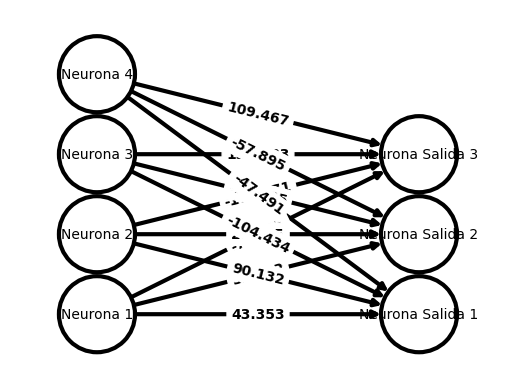

In [29]:
G = nx.DiGraph()
input_layer = [f'Neurona {i + 1}' for i in range(n_neuronas_entrada)]
output_layer = [f'Neurona Salida {i + 1}' for i in range(n_neuronas_salida)]
layers = [input_layer, output_layer]
rels = list(itertools.product(input_layer, output_layer))
weights_labels = {(ra, rb): "{:0.3f}".format(pesos_sinapticos[i][j]) for i, ra in enumerate(input_layer) for j, rb in enumerate(output_layer)}
pos = {node: (layer_idx, node_idx) for layer_idx, layer in enumerate(layers) for node_idx, node in enumerate(layer)}
G.add_edges_from(rels)
options = {
    "font_size": 10,
    "node_size": 3000,
    "node_color": [(1, 1, 1, 1) for _ in range(len(pos))],
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
    "labels": {node: node for node in pos},
    "connectionstyle": "arc3, rad=0",
}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=weights_labels,
    font_color='black',
    font_size=10,
    font_weight='bold'
)
plt.axis('off')
ax = plt.gca()
ax.margins(0.20)
plt.show()



**¿Como modificarían la estructura de la red para que admita  capas ocultas con  neuronas cada una? Describir como sería el algoritmo de forward propagation en este caso, no es necesario implementar el algoritmo de back propagation.**


Para añadir capas ocultas con \( n \) neuronas cada una a la red, primero decidimos cuántas capas ocultas queremos y ponemos \( n \) neuronas en cada una. Luego, creamos unas tablas especiales de números (llamadas matrices de pesos) y unos listados de números (vectores de sesgos) para cada conexión entre capas seguidas.

Ahora, en el proceso de Forward Propagation:

1. Tomamos los datos de entrada, los multiplicamos por los números en la tabla de la primera capa oculta, sumamos los números del listado, y luego pasamos el resultado por una función especial que nos da las activaciones de la primera capa oculta.
2. Para cada capa oculta que sigue, tomamos las activaciones de la capa anterior, las multiplicamos por los números en la tabla de la capa actual, sumamos los números del listado de la capa actual, y pasamos el resultado por la función especial para obtener las activaciones de la capa actual.
3. Al final, tomamos las activaciones de la última capa oculta, las multiplicamos por los números hacia la capa de salida, sumamos los números del listado de la capa de salida, y pasamos el resultado por una función especial para obtener las salidas finales de la red.

